## Orqviz demo - How to get started (using Qiskit!)

This notebook demonstrates how to get started with the _orqviz_ python package by Zapata Computing, Inc.
The quantum computing framework used here is IBM's _Qiskit_ package.

The example algorithm in the demo is the _Variational Quantum Eigensolver_ (VQE) algorithm on a 2-qubit Hamiltonian for the H2 molecule. The goal of this algorithm is to minimize the energy of a parameterized quantum state on the Hamiltonian in order to approximate the ground state energy.

<div class="alert alert-block alert-info">
To execute this notebook, you will need to install: numpy, matplotlib, qiskit, and orqviz.
</div>

#### Version Information

| __Software__     | __Version__ |
| ---------------- | ----------- |
| qiskit           | 0.34.1      |
| numpy            | 1.21.4      |
| matplotlib       | 3.5.1       |

Let's get started!

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.compiler import transpile
from qiskit.opflow.state_fns.circuit_state_fn import CircuitStateFn

### Load the Hamiltonian

In [3]:
with open('data/h2_ham_2q_qiskit', 'r') as reader:
    data = reader.readlines()
    ham_list = []
    for line in data:
        pauli_str, coeff = line.split()
        ham_list.append((pauli_str, float(coeff)))

H = SparsePauliOp.from_list(ham_list).to_matrix()
print(H)

exact_g_energy = -1.145832178075

[[ 0.7349684 +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -1.12612559+0.j  0.18038417+0.j  0.        +0.j]
 [ 0.        +0.j  0.18038417+0.j  0.50531369+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.95501098+0.j]]


This Hamiltonian _H_ contains X, Y and Z Pauli operators for two qubits. The goal is to prepare a quantum state, such that the sum of all the Pauli operator expectations with their respective coefficients is as low as possible. The best possible energy one can reach with this Hamiltonian is the exact ground state energy of -1.145832 Hartrees.

### Define my circuit

Let's import the necessary components to construct our parameterized quantum circuit. Below, we construct a simple two-qubit circuit that comprises RY and CNOT gates. The CNOT gate is applied if there is more than one entangling layer. 

In [4]:
def get_circuit(param_vector, n_entangling_layers=0):

    n_qubits = 2
    
    circuit = QuantumCircuit(n_qubits)
    circuit.x(0)
    parameter_index = 0
    
    for ii in range(n_qubits):
        circuit.ry(param_vector[parameter_index], ii)
        parameter_index += 1

    for _ in range(n_entangling_layers):
        circuit.cx(0, 1)

        for ii in range(n_qubits):
            circuit.ry(param_vector[parameter_index], ii)
            parameter_index += 1
            
    # transpile the circuit before returning
 
    return transpile(circuit)

### Define my loss function (i.e. energy expectation)

The most important routine needed to visualize the loss landscape of variational quantum algorithms is the _loss function_. The loss function takes in a vector of parameters, and returns a float/number which represents the _loss_. The loss function hides all the complicated quantum circuit shenanigans under the hood. Loss functions are sometimes also referred to as _cost functions_. 

In our VQE example, our loss is the energy, as we want to minimize it. Here, we define the function *calculate_energy*. It doesn't yet only receive parameters, but we will deal with that in a bit.

In [5]:
def calculate_energy(parameters, transpiled_circuit, param_vector):
    """
    Function that receives parameters for a quantum circuit, as well as specifications for the circuit depth,
    and returns the energy over a previously defined Hamiltonian H.
    """
    # bind the parameter values for this calculation to the transpiled circuit
    final_circuit = transpiled_circuit.bind_parameters({param_vector:parameters})
    
    # convert to a state (do this only for small systems)
    psi = CircuitStateFn(final_circuit)
    return np.dot(psi.adjoint().to_matrix(), np.dot(H, psi.to_matrix())).real

As you might have noticed, `calculate_energy` has two inputs – `parameters` and `n_entangling_layers`. However, we said that in `orqviz` your loss function needs to take in only `parameters`. How do we deal with that?

There are a couple of ways to do this:
- use [`functools.partial`](https://docs.python.org/3/library/functools.html)
- define a [closure function](https://www.programiz.com/python-programming/closure)
- use our `LossFunctionWrapper` utility tool.

Let's focus on the last option – we added it to `orqviz` for people who don't feel comfortable with the other two options. `LossFunctionWrapper` is a utility tool which allows you to transform whatever function you want into a orqviz-compatible loss function that takes in only parameters.

You just need to set all the other parameters to some constant value, we'll see this in action in a moment.

### Specify the quantum circuit 

We start out with no entanglement (i.e. no entangling operations) in the quantum circuit. This results in only 2 parameters.
Additionally, we wrap our loss function with those specifications such that it only receives parameters.

In [6]:
n_entangling_layers = 0

n_params = 2 + 2*n_entangling_layers
param_vector = ParameterVector('param_vector', n_params)

transpiled_circuit = get_circuit(param_vector, n_entangling_layers)

In [7]:
from orqviz.loss_function import LossFunctionWrapper

initial_parameters = np.array([ 0.5896798 , -0.53733806])

loss_function = LossFunctionWrapper(calculate_energy, transpiled_circuit=transpiled_circuit, param_vector=param_vector)

Let's try computing the energy of our initial parameterized state.

In [8]:
loss_function(initial_parameters)

-0.8104077773325067

As a sidenote, `LossFunctionWrapper` has some additional utilities that you might find useful:

In [9]:
print("Call count:", loss_function.call_count)
print("Min value:", loss_function.min_value)
print("Average call time:", loss_function.average_call_time)
loss_function.reset() # this resets all the fields printed out above

Call count: 1
Min value: -0.8104077773325067
Average call time: 0.011267752999998493


What does the circuit look like?

In [10]:
circuit = get_circuit(initial_parameters, n_entangling_layers)
print(circuit)

          ┌───┐      ┌─────────────┐
q_0: ─────┤ X ├──────┤ Ry(0.58968) ├
     ┌────┴───┴─────┐└─────────────┘
q_1: ┤ Ry(-0.53734) ├───────────────
     └──────────────┘               


In order to optimize our circuit, we grab a simple gradient descent optimizer from a local python file and a function to calculate a numerical gradient from _orqviz_.

In [11]:
from gradient_descent_optimizer import gradient_descent_optimizer
from orqviz.gradients import calculate_full_gradient

def gradient_function(parameters):
    return calculate_full_gradient(parameters, loss_function, stochastic=False, eps=1e-3)

### Optimize the circuit

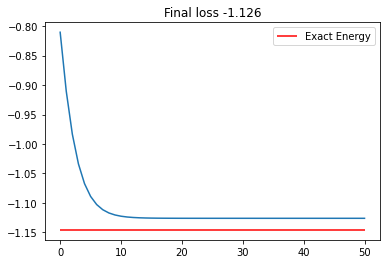

In [12]:
n_iters = 50
parameter_trajectory, losses = gradient_descent_optimizer(initial_parameters, 
                                                          loss_function, 
                                                          n_iters, 
                                                          learning_rate=0.2, 
                                                          full_gradient_function=gradient_function)
final_parameters = parameter_trajectory[-1]

plt.plot(losses)
plt.hlines(exact_g_energy, 0, n_iters, color="red", label="Exact Energy")
plt.title("Final loss {:.3f}".format(losses[-1]))
plt.legend()
plt.show()

This yields a final energy error of:

In [13]:
np.min(losses)-exact_g_energy

0.019706586358939848

What do we know about the problem so far? We know that optimizing with gradient descent is straightforward, but we haven't converged to a very good solution. Can we expect a solution better than this? Is this just a local minimum? VQE problems typically require a solution with error that is on the order of $10^{-3}$ Hartrees. 

For a better understanding of the problem and the optimization, we will use various methods from _orqviz_ in the following cells.

### Import visualization methods and start plotting

First, let's interpolate between the initial and solution parameters to get a feel of the landscape that we are trying to traverse.

In [14]:
from orqviz.scans import perform_1D_interpolation, plot_1D_interpolation_result

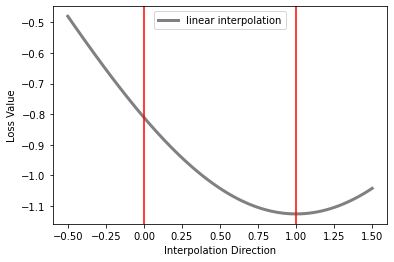

In [15]:
end_points = (-0.5, 1.5)

interpolation_result = perform_1D_interpolation(initial_parameters, final_parameters, 
                                                loss_function, end_points=end_points)

plot_1D_interpolation_result(interpolation_result, label="linear interpolation", color="gray")

plt.legend()
plt.show()

The red lines indicate the points you interpolate between, i.e. initial and final parameters.

This looks very nice and convex. But is this all there is to see? Let's see this in 2D!

In [16]:
from orqviz.scans import perform_2D_scan, plot_2D_scan_result

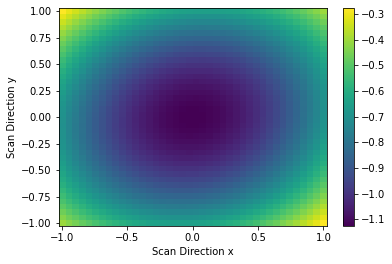

In [17]:
dir1 = np.array([1., 0.])
dir2 = np.array([0., 1.])

scan_2D_result = perform_2D_scan(final_parameters, loss_function, 
                                 direction_x=dir1, direction_y=dir2, n_steps_x=40)

plot_2D_scan_result(scan_2D_result)

Even in 2D it looks very well-behaved. We only have two parameters, so this plot is the exact landscape we are optimizing.

But what was the path that we optimized? Let's see it with Principal Component Analysis (PCA)! In the case of 2 parameters, running PCA is a bit silly, but these plots can be useful for visualizing high-dimensional landscapes. We show the code for running PCA below, and this should work for any loss landscape with >2 parameters.

In [18]:
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)

In [19]:
pca = get_pca(parameter_trajectory)
scan_pca_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=40)

Note that our plotting functions allow for full flexibility with matplotlib. Any keywords that you would pass for plotting manually, you can pass to our plotting functions.

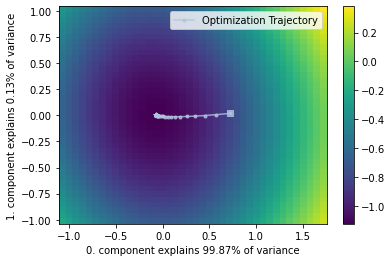

In [20]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory, pca, ax=ax, 
                                    label="Optimization Trajectory", color="lightsteelblue")
plt.legend()
plt.show()

Because the landscape is so simple, optimization moves almost in a straight line.

### Let's zoom out a little!

We can do so by setting the `offset` to a higher number. `offset` is the distance we leave between the edges of our trajectory and the border of the scan.

In [21]:
scan_pca_result2 = perform_2D_pca_scan(pca, loss_function, n_steps_x=50, offset=8)

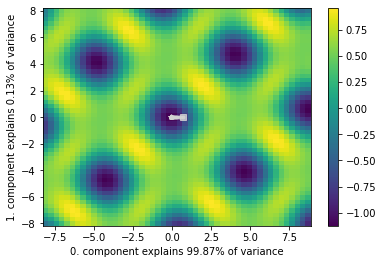

In [22]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result2, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory, pca, ax=ax)

With this two-dimensional loss landscape, we can see the periodicity and notice that we do not sit in a bad local minimum. 

### How about adding more layers in the quantum circuit?

So far, we didn't include any entanglement in the quantum circuit. We will change this now!

In [23]:
n_entangling_layers2 = 1

n_params = 2 + 2*n_entangling_layers2
param_vector = ParameterVector('param_vector', n_params)

transpiled_circuit2 = get_circuit(param_vector, n_entangling_layers2)

initial_parameters2 = np.array([ 1.12840278, -1.85964912, -1.1847599 ,  1.27278466])

loss_function2 = LossFunctionWrapper(calculate_energy, transpiled_circuit=transpiled_circuit2, param_vector=param_vector)

def gradient_function2(parameters):
    return calculate_full_gradient(parameters, loss_function2, stochastic=False, eps=1e-3)

The algorithm now has a 4-dimensional loss landscape. How do we even visualize that? In the exact same way! Our functions are fully flexible.

### Optimize again!

In [24]:
n_iters = 50
parameter_trajectory2, losses2 = gradient_descent_optimizer(initial_parameters2, 
                                                            loss_function2, 
                                                            n_iters, 
                                                            learning_rate=0.2, 
                                                            full_gradient_function=gradient_function2)
final_parameters2 = parameter_trajectory2[-1]

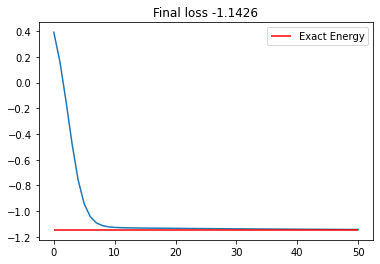

In [25]:
plt.plot(losses2)
plt.hlines(exact_g_energy, 0, n_iters, color="red", label="Exact Energy")
plt.title("Final loss {:.4f}".format(losses2[-1]))
plt.legend()
plt.show()

Much better! We have a final energy error of:

In [26]:
np.min(losses2)-exact_g_energy

0.003257722988059042

How did we traverse the loss landscape this time?

CPU times: user 21.8 s, sys: 287 ms, total: 22.1 s
Wall time: 22.5 s


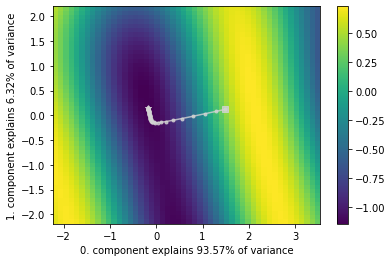

In [27]:
%%time

pca2 = get_pca(parameter_trajectory2)
scan_pca_result3 = perform_2D_pca_scan(pca2, loss_function2, n_steps_x=50, offset=2)

fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result3, pca2, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory2, pca2, ax=ax)

This looks a little more complicated but still rather smooth. Note that with 4 parameters, this 2D scan is no longer an exact representation of the loss landscape. The scan is computing the loss on a 2D plane that "slices" the 4D space, and the parameter trajectory is _projected_ on the scan. The x and y labels indicate how representative the scan directions are for the trajectory and how big the degree of approximation is when projecting.

Let's try zooming out again by increasing the `offset`:

CPU times: user 21.9 s, sys: 198 ms, total: 22.1 s
Wall time: 22.3 s


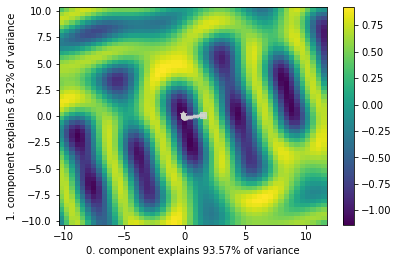

In [28]:
%%time

scan_pca_result4 = perform_2D_pca_scan(pca2, loss_function2, n_steps_x=50, offset=10)

fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result4, pca2, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory2, pca2, ax=ax)

This looks much more involved and is no longer exactly periodic in the directions of our scan.

_orqviz_ offers more than these simpler scans to help us understand the loss landscapes!

### What does the Hessian tell us?

In [29]:
from orqviz.hessians import get_Hessian

The function *get_Hessian* returns a numerically calculated Hessian of the loss function at a specified point in parameter space. The Hessian is a matrix of second partial derivatives of the loss, and as such, contains information about the _curvature_. 

In [30]:
%%time
hessian1 = get_Hessian(params=final_parameters, loss_function=loss_function, eps=1e-3)
hessian2 = get_Hessian(params=final_parameters2, loss_function=loss_function2, eps=1e-3)

CPU times: user 323 ms, sys: 8.37 ms, total: 331 ms
Wall time: 329 ms


Calculating Hessians can be very expensive, as the number of loss function evaluations scales **quadratically** with the number of parameters. This is why _orqviz_ also provides an approximation of the Hessian with *get_Hessian_SPSA_approximation*. But let's not get ahead of ourselves. For now, this is very fast!

What are the eigenvalues of the Hessian?

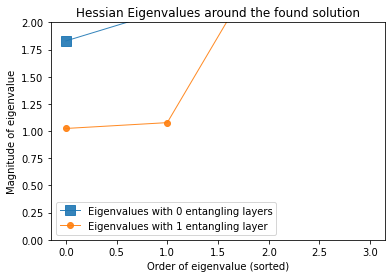

In [31]:
plt.plot(hessian1.eigenvalues, label=f"Eigenvalues with {n_entangling_layers} entangling layers", 
         alpha=0.9, linewidth=1, marker="s", ms=10)
plt.plot(hessian2.eigenvalues, label=f"Eigenvalues with {n_entangling_layers2} entangling layer", 
         alpha=0.9, linewidth=1, marker="o")
plt.legend()
plt.ylim(0,2)
plt.title("Hessian Eigenvalues around the found solution")
plt.xlabel("Order of eigenvalue (sorted)")
plt.ylabel("Magnitude of eigenvalue")
plt.show()

All eigenvalues are positive, which means that the Hessian is _positive-definite_ and we are in a convex region.

We can also scan in the direction of the eigenvectors to see what it means to be in a convex region.

In [32]:
from orqviz.hessians import perform_1D_hessian_eigenvector_scan, plot_1D_hessian_eigenvector_scan_result

In [33]:
hessian1_eigvec_scans = perform_1D_hessian_eigenvector_scan(hessian1, loss_function, n_points=31)
hessian2_eigvec_scans = perform_1D_hessian_eigenvector_scan(hessian2, loss_function2, n_points=31)

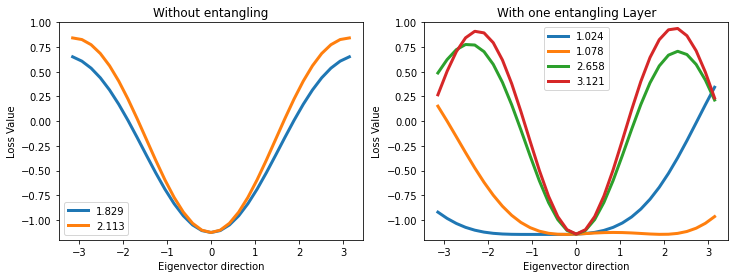

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

plot_1D_hessian_eigenvector_scan_result(hessian1_eigvec_scans, eigenvalues=hessian1.eigenvalues, ax=ax1)
plot_1D_hessian_eigenvector_scan_result(hessian2_eigvec_scans, eigenvalues=hessian2.eigenvalues, ax=ax2)

ax1.set_ylim(-1.2,1.0)
ax2.set_ylim(-1.2,1.0)
ax1.set_title("Without entangling")
ax2.set_title("With one entangling Layer")
plt.show()

We see the energy mostly increases around our found solution when we scan in the directions of the Hessian eigenvectors. The respective eigenvalues of the eigenvectors are shown in the plot legend. We also see that there seem to be extensive low-energy regions around our solution. A 2D eigenvector scan can help us visualize that! Here we choose the eigenvectors as scan directions for 2D scans. 

In [35]:
# A helper function to normalize the color ranges of the scans
from orqviz.plot_utils import normalize_color_and_colorbar

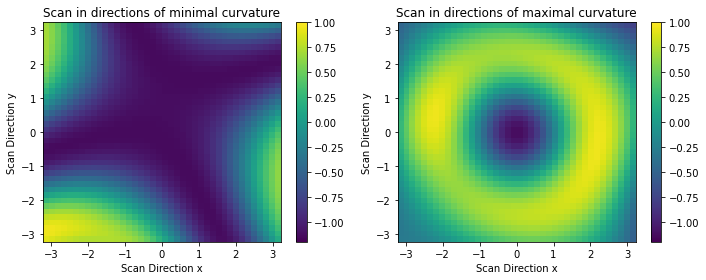

CPU times: user 28 s, sys: 343 ms, total: 28.4 s
Wall time: 28.4 s


In [36]:
%%time
scale_factor = np.pi  # how much to scan in the direction? The eigenvectors are normalized.

scan_hess2_low = perform_2D_scan(parameter_trajectory2[-1], loss_function2, 
                                 direction_x=hessian2.eigenvectors[0]*scale_factor, 
                                 direction_y=hessian2.eigenvectors[1]*scale_factor,
                                 n_steps_x=40)
scan_hess2_high = perform_2D_scan(parameter_trajectory2[-1], loss_function2, 
                                 direction_x=hessian2.eigenvectors[-1]*scale_factor, 
                                 direction_y=hessian2.eigenvectors[-2]*scale_factor,
                                 n_steps_x=40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
plot_2D_scan_result(scan_hess2_low, fig=fig, ax=ax1)
plot_2D_scan_result(scan_hess2_high, fig=fig, ax=ax2)

normalize_color_and_colorbar(fig=fig, ax=ax1, min_val=-1.2, max_val=1)
normalize_color_and_colorbar(fig=fig, ax=ax2, min_val=-1.2, max_val=1)

ax1.set_title("Scan in directions of minimal curvature")
ax2.set_title("Scan in directions of maximal curvature")
plt.tight_layout()
plt.show()

Informed by the Hessian, we were able to choose scan directions in which the loss increases very slowly or very quickly! 

Does this mean that there are low-energy paths throughout the landscape? Let's test this with the _Nudged Elastic Band_ in our _orqviz_ package.

But first...

### Find a second solution for the case with entanglement

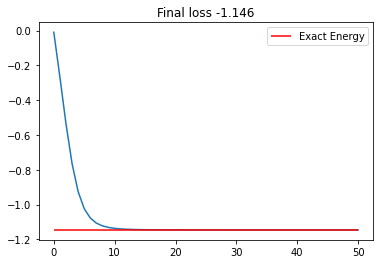

In [37]:
n_iters = 50
initial_parameters3 = initial_parameters2 + np.array([-1.7, -2.3, -3.1,  2.8])

parameter_trajectory3, losses3 = gradient_descent_optimizer(initial_parameters3, loss_function2, n_iters, 
                                                          learning_rate=0.2, full_gradient_function=gradient_function2)
final_parameters3 = parameter_trajectory3[-1]

plt.plot(losses3)
plt.hlines(exact_g_energy, 0, n_iters, color="red", label="Exact Energy")
plt.title("Final loss {:.3f}".format(losses3[-1]))
plt.legend()
plt.show()

Let's run PCA's on both optimization trajectories to see where they went.

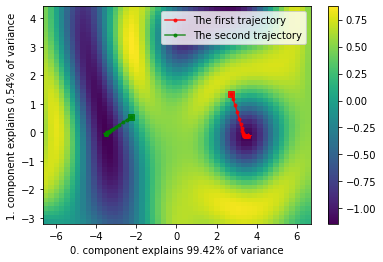

CPU times: user 21.9 s, sys: 258 ms, total: 22.1 s
Wall time: 22.3 s


In [38]:
%%time

pca3 = get_pca(np.append(parameter_trajectory2, parameter_trajectory3, axis=0))
scan_pca_result5 = perform_2D_pca_scan(pca3, loss_function2, n_steps_x=50, offset=3)

fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result5, pca3, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory2, pca3, ax=ax, color="red", label="The first trajectory")
plot_optimization_trajectory_on_pca(parameter_trajectory3, pca3, ax=ax, color="green", label="The second trajectory")
plt.legend()
plt.show()

This doesn't look like the two found solutions are connected at all... or are they?

### Get the Nudged Elastic Band going!

In [39]:
from orqviz.elastic_band import Chain, ChainPath, run_NEB

In [40]:
initial_chain = Chain(np.linspace(final_parameters2, final_parameters3, num=10))
initial_path = ChainPath(initial_chain)

all_chains = run_NEB(initial_chain, loss_function2, 
                     n_iters=100, eps=1e-3, learning_rate=0.1)
trained_chain = all_chains[-1]
trained_path = ChainPath(trained_chain)

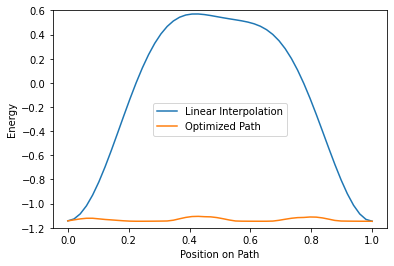

In [41]:
linear_loss = initial_path.evaluate_points_on_path(50, loss_function2)
trained_loss = trained_path.evaluate_points_on_path(50, loss_function2)

plt.plot(np.linspace(0,1,50), linear_loss, label="Linear Interpolation")
plt.plot(np.linspace(0,1,50), trained_loss, label="Optimized Path")
plt.ylabel("Energy")
plt.xlabel("Position on Path")
plt.legend()
plt.ylim(-1.2, 0.6)
plt.show()

There seems to be a path connecting the two found minima! Let's see it with PCA.

In [42]:
pca_from_chain = get_pca(trained_chain.pivots)
pca_chain_scan = perform_2D_pca_scan(pca_from_chain, loss_function2, n_steps_x=40, offset=3)

In [43]:
from orqviz.pca import plot_line_through_points_on_pca

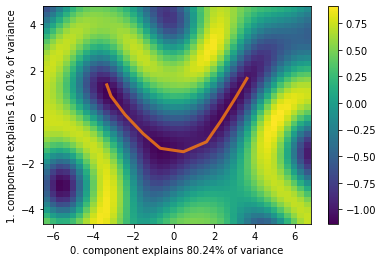

In [44]:
fig, ax = plt.subplots()
plot_pca_landscape(pca_chain_scan, pca_from_chain, fig=fig, ax=ax)
plot_line_through_points_on_pca(trained_chain.pivots, pca_from_chain, ax=ax, linewidth=3, color="tab:orange")

This looks very impressive! But the points seem very far apart. Given the periodicity of the gate parameters in our circuit, couldn't there be a shorter path? 

In fact, yes! Visualization techniques partially rely on respecting the symmetries of the loss function in order to produce the most valuable outcome. In the case of parameterized quantum circuits with Pauli gates like $Rx, Ry,$ and $Ry$,  all parameters are $2\pi$-periodic, meaning that we get the same loss (and the same state) if we add multiples of $2\pi$ to any or all parameters. Not only that, but the "shortest path" between two points in this periodic space is affected even more. _orqviz_ provides the following functions to _wrap_ parameters according to the periodicity of the parameters:

In [45]:
from orqviz.geometric import relative_periodic_wrap, relative_periodic_trajectory_wrap

`relative_periodic_wrap` wraps a point to the closest copy of itself with respect to a reference point. `relative_periodic_trajectory_wrap` wraps a parameter trajectory to a copy of itself such that the final point is the closest copy to a reference point. If we apply that to the two solutions that we found, this is what we get:

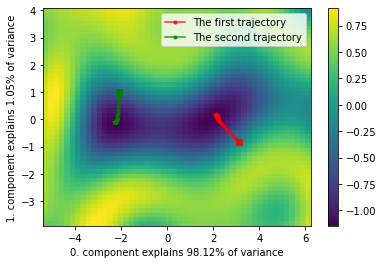

CPU times: user 22.2 s, sys: 391 ms, total: 22.6 s
Wall time: 22.9 s


In [46]:
%%time

wrapped_parameter_trajectory3 = relative_periodic_trajectory_wrap(final_parameters2, parameter_trajectory3)

pca3 = get_pca(np.append(parameter_trajectory2, wrapped_parameter_trajectory3, axis=0))
scan_pca_result5 = perform_2D_pca_scan(pca3, loss_function2, n_steps_x=50, offset=3)

fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result5, pca3, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(parameter_trajectory2, pca3, ax=ax, color="red", label="The first trajectory")
plot_optimization_trajectory_on_pca(wrapped_parameter_trajectory3, pca3, ax=ax, color="green", label="The second trajectory")
plt.legend()
plt.show()

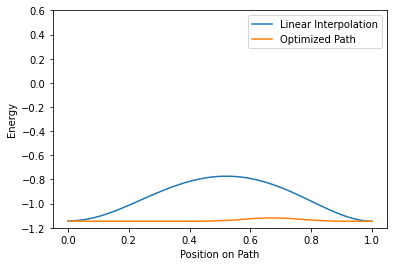

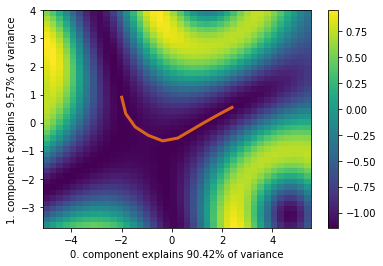

In [47]:
wrapped_final_parameters3 = relative_periodic_wrap(final_parameters2, final_parameters3)

initial_chain2 = Chain(np.linspace(final_parameters2, wrapped_final_parameters3, num=10))
initial_path2 = ChainPath(initial_chain2)
###
all_chains2 = run_NEB(initial_chain2, loss_function2, n_iters=100, eps=1e-3, learning_rate=0.1)
trained_chain2 = all_chains2[-1]
trained_path2 = ChainPath(trained_chain2)
###
linear_loss2 = initial_path2.evaluate_points_on_path(50, loss_function2)
trained_loss2 = trained_path2.evaluate_points_on_path(50, loss_function2)
###
plt.plot(np.linspace(0,1,50), linear_loss2, label="Linear Interpolation")
plt.plot(np.linspace(0,1,50), trained_loss2, label="Optimized Path")
plt.ylabel("Energy")
plt.xlabel("Position on Path")
plt.legend()
plt.ylim(-1.2, 0.6)
plt.show()
###
pca_from_chain2 = get_pca(trained_chain2.pivots)
pca_chain_scan2 = perform_2D_pca_scan(pca_from_chain2, loss_function2, n_steps_x=40, offset=3)
###
fig, ax = plt.subplots()
plot_pca_landscape(pca_chain_scan2, pca_from_chain2, fig=fig, ax=ax)
plot_line_through_points_on_pca(trained_chain2.pivots, pca_from_chain2, ax=ax, linewidth=3, color="tab:orange")

The points were not separated by very high energy regions after all. 

This is a much richer picture than what we would have initially expected from just observing the optimization performance for 0 and 1 entangling layers (i.e. plotting the energy as a function of training epochs). Don't you agree?

### For more ways to analyze loss landscapes of parameterized quantum circuits, check out the rest of the _orqviz_ package!